# Predictive Uncertainty Estimation using Deep Ensemble (Regression)

## Dataset: Real dataset (Concrete Compressive Strength Dataset)

This algorithm is implementation of paper [Simple and Scalable Predictive Uncertainty Estimation using Deep Ensembles](https://arxiv.org/abs/1612.01474). In this jupyter notebook, I will implement regression part of this paper using [Concrete Compressive Strength Dataset](https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength)

## Import Modules

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas

## Parameters

In [17]:
# Parameters of training
Learning_rate = 0.0001
epsilon = 1e-8

num_iter = 25000
batch_size = 256

test_ratio = 0.1
gpu_fraction = 0.5

# Ensemble networks (5 networks)
networks = ['network1', 'network2', 'network3', 'network4', 'network5']

# Import Excel File
data = pandas.read_excel('Concrete_Data.xls')
column_names = data.columns

num_rows = len(data)
num_columns = len(column_names) 
num_data = num_columns - 1

# Dense [input size, output size]
dense1 = [num_data, 256]
dense2 = [256, 512]
dense3 = [512, 1024]
dense_mu  = [1024, 1]
dense_sig = [1024, 1]


## Get Concrete Dataset

The concrete dataset has `8 features` which are as follows
- Cement
- Blast Furnace Slag
- Fly Ash 
- Superplasticizer
- Coarse Aggregate
- Fine Aggregate
- Age (day)

Also, it has `1 output`
- Concrete Compressive Strength

The example data is as follows
<img src="./image/Concrete_dataset.PNG" width="800" alt="Concrete Dataset" />

In [3]:
data_x = np.zeros([num_rows, num_columns - 1])
data_y = np.zeros([num_rows, 1])

for i in range(num_rows):
    for j in range(num_columns - 1):
        data_x[i, j] = data[column_names[j]][i]
    data_y[i,0] = data[column_names[-1]][i]

num_train_data = int(num_rows * (1 - test_ratio))
num_test_data  = num_rows - num_train_data

train_x = data_x[:num_train_data, :]
train_y = data_y[:num_train_data, :]
test_x  = data_x[num_train_data:, :]
test_y  = data_y[num_train_data:, :]

print("Train data shape: " + str(train_x.shape))
print("Test data shape: " + str(test_x.shape))

Train data shape: (927, 8)
Test data shape: (103, 8)


## Functions

In [9]:
tf.reset_default_graph()

def weight_variable(name, shape):
    return tf.get_variable(name, shape = shape, initializer = tf.contrib.layers.xavier_initializer(), dtype = tf.float64)

def bias_variable(name, shape):
    return tf.get_variable(name, shape = shape, initializer = tf.contrib.layers.xavier_initializer(), dtype = tf.float64)

# Get networks
def get_network(network_name):
    input_x = tf.placeholder(tf.float64, shape = [None, num_data])
    
    with tf.variable_scope(network_name):
        # Densely connect layer variables
        w_fc1 = weight_variable(network_name + '_w_fc1', dense1)
        b_fc1 = bias_variable(network_name + '_b_fc1', [dense1[1]])
        
        w_fc2 = weight_variable(network_name + '_w_fc2', dense2)
        b_fc2 = bias_variable(network_name + '_b_fc2', [dense2[1]])

        w_fc3 = weight_variable(network_name + '_w_fc3', dense3)
        b_fc3 = bias_variable(network_name + '_b_fc3', [dense3[1]])
        
        w_fc_mu = weight_variable(network_name + '_w_fc_mu', dense_mu)
        b_fc_mu = bias_variable(network_name + '_b_fc_mu', [dense_mu[1]])

        w_fc_sig = weight_variable(network_name + '_w_fc_sig', dense_sig)
        b_fc_sig = bias_variable(network_name + '_b_fc_sig', [dense_sig[1]])

    # Network
    fc1 = tf.nn.relu(tf.matmul(input_x, w_fc1) + b_fc1)
    fc2 = tf.nn.relu(tf.matmul(fc1, w_fc2) + b_fc2)
    fc3 = tf.nn.relu(tf.matmul(fc2, w_fc3) + b_fc3)
    output_mu  = tf.matmul(fc3, w_fc_mu) + b_fc_mu
    output_sig = tf.matmul(fc3, w_fc_sig) + b_fc_sig
    output_sig_pos = tf.log(1 + tf.exp(output_sig)) + 1e-06
    
    y = tf.placeholder(tf.float64, shape = [None, 1])
    
    # Negative Log Likelihood(NLL) 
    loss = tf.reduce_mean(0.5*tf.log(output_sig_pos) + 0.5*tf.div(tf.square(y - output_mu),output_sig_pos)) + 5

    # Get trainable variables
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, network_name) 
    
    # Gradient clipping for preventing nan
    optimizer = tf.train.AdamOptimizer(learning_rate = Learning_rate)
    gvs = optimizer.compute_gradients(loss, var_list = train_vars)
    capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
    train_opt = optimizer.apply_gradients(capped_gvs)

    return input_x, y, output_mu, output_sig_pos, loss, train_opt, train_vars


# Make batch data 
def making_batch(data_size, sample_size, data_x, data_y):
    
    # Making batches(testing)
    batch_idx = np.random.choice(data_size, sample_size)
    
    batch_x = np.zeros([sample_size, num_data])
    batch_y = np.zeros([sample_size, 1])
        
    for i in range(batch_idx.shape[0]):
        batch_x[i,:] = data_x[batch_idx[i], :]
        batch_y[i,:] = data_y[batch_idx[i], :] 
        
    return batch_x, batch_y   

## Initialize Ensemble Networks

In [10]:
x_list = []
y_list = []
output_mu_list = []
output_sig_list = []
loss_list = []
train_list = []
train_var_list = []
output_test_list = []

# Train each ensemble network
for i in range(len(networks)):
    x_input, y, output_mu, output_sig, loss, train_opt, train_vars = get_network(networks[i])

    x_list.append(x_input)
    y_list.append(y)
    output_mu_list.append(output_mu)
    output_sig_list.append(output_sig)
    loss_list.append(loss)
    train_list.append(train_opt)
    train_var_list.append(train_vars)


## Create Session

In [11]:
# Create Session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = gpu_fraction

sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())

## Training

In [18]:
# Set parameters for printing and testing
num_print = 100
test_size = 10

train_data_num = train_x.shape[0]
test_data_num  = test_x.shape[0]

loss_train = np.zeros([len(networks)])
out_mu     = np.zeros([test_size, len(networks)])
out_sig    = np.zeros([test_size, len(networks)])

for iter in range(num_iter):
    # Making batches(testing)
    batch_x_test, batch_y_test = making_batch(test_data_num, test_size, test_x, test_y)
        
    for i in range(len(networks)):
        # Making batches(training)
        batch_x, batch_y = making_batch(train_data_num, batch_size, train_x, train_y)
       
        # Training
        _, loss, mu, sig = sess.run([train_list[i], loss_list[i], output_mu_list[i], output_sig_list[i]], 
                                               feed_dict = {x_list[i]: batch_x, y_list[i]: batch_y})
  
      
        # Testing
        loss_test, mu_test, sig_test = sess.run([loss_list[i], output_mu_list[i], output_sig_list[i]], 
                                    feed_dict = {x_list[i]: batch_x_test, y_list[i]: batch_y_test})

        if np.any(np.isnan(loss)):
            raise ValueError('There is Nan in loss')
        
        loss_train[i] += loss
        out_mu[:, i] = np.reshape(mu_test, (test_size))
        out_sig[:, i] = np.reshape(sig_test, (test_size))
        
    # Get final test result
    out_mu_final = np.mean(out_mu, axis = 1)
    out_sig_final = np.sqrt(np.mean(out_sig + np.square(out_mu), axis = 1) - np.square(out_mu_final))
    
    if iter % num_print == 0 and iter != 0:
        print(('-------------------------') + ' Iteration: ' + str(iter) + ' -------------------------')
        print('Average Loss(NLL): ' + str(loss_train / num_print))
        print('mu: ' + str(out_mu[0, :]))
        print('std: ' + str(np.sqrt(out_sig[0, :])))
        print('Final mu: ' + str(out_mu_final[0]))
        print('Final std: ' + str(out_sig_final[0]))
        print('Real Value: ' + str(batch_y_test[0]))
        print('\n')
        
        loss_train = np.zeros(len(networks))


------------------------- Iteration: 100 -------------------------
Average Loss(NLL): [ 7.1227976   6.93717292  6.96967315  6.68269475  7.07954605]
mu: [ 31.64415622  33.08406128  34.78902511  40.11553826  43.29039964]
std: [ 5.96485641  1.19675202  3.83346699  3.85418339  7.57616149]
Final mu: 36.584636101
Final std: 6.65253738188
Real Value: [ 22.93197176]


------------------------- Iteration: 200 -------------------------
Average Loss(NLL): [ 7.05416829  6.87199143  6.67054638  6.71863251  8.91700372]
mu: [ 19.18782016   8.85708147  12.04495692  10.789022    24.63717765]
std: [ 5.30131475  2.85445537  5.00743174  4.82052051  9.62615261]
Final mu: 15.1032116401
Final std: 8.38792333223
Real Value: [ 12.4595208]


------------------------- Iteration: 300 -------------------------
Average Loss(NLL): [ 7.06032981  6.87040255  6.91437784  6.61743589  8.25358499]
mu: [ 29.48438247  40.03754633  36.13196557  38.2667409   42.17701198]
std: [ 3.52907858  4.05282453  5.08960827  2.84601329  

## Testing with Known and Unknown Data

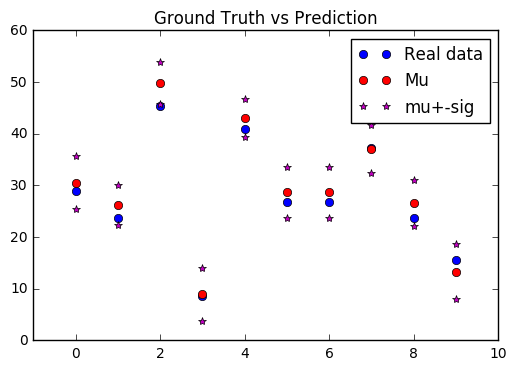

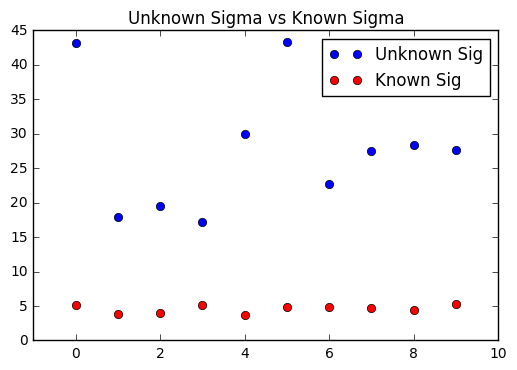

In [22]:
# Get Unknown dataset and test 
x_sample = np.random.randint(0, 50, size = (test_size,num_data))

out_mu_sample  = np.zeros([test_size, len(networks)])
out_sig_sample = np.zeros([test_size, len(networks)])

for i in range(len(networks)):
    mu_sample, sig_sample = sess.run([output_mu_list[i], output_sig_list[i]], 
                                      feed_dict = {x_list[i]: x_sample})

    out_mu_sample[:,i]  = np.reshape(mu_sample, (test_size))
    out_sig_sample[:,i] = np.reshape(sig_sample, (test_size))

out_mu_sample_final  = np.mean(out_mu_sample, axis = 1)
out_sig_sample_final = np.sqrt(np.mean(out_sig_sample + np.square(out_mu_sample), axis = 1) - np.square(out_mu_sample_final))

# Plot mean and variable vs real data 
plt.figure(1)
plt.hold
plt.plot(batch_y_test, 'bo')
plt.plot(out_mu_final, 'ro')
plt.plot(out_mu_final + out_sig_final, 'm*')
plt.plot(out_mu_final - out_sig_final, 'm*')
plt.legend(['Real data', 'Mu', 'mu+-sig'], loc = 'best')
plt.title('Ground Truth vs Prediction')
plt.xlim([-1, 10])

# Plot comparison of known sig and unknown sig
plt.figure(2)
plt.hold
plt.plot(out_sig_sample_final, 'bo')
plt.plot(out_sig_final, 'ro')
plt.legend(['Unknown Sig', 'Known Sig'], loc = 'best')
plt.title('Unknown Sigma vs Known Sigma')
plt.xlim([-1, 10])

plt.show()